# 6.2 Keras로 MF 구현하기

In [1]:
# csv 파일에서 불러오기
import  pandas as pd

# train set과 test set을 나누기 위한 라이브러리
from sklearn.model_selection import train_test_split

# 필요한 tensorflow 모듈들을 가져온다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./Data/u.data',
                        names=r_cols,
                        sep='\t',
                        encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                                test_size=0.2,
                                                shuffle=True,
                                                random_state=2021)

In [2]:
K = 200

mu = ratings_train.rating.mean()

M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1      # bias_com의 크기 1을 감안하는 것!

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))



In [3]:
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [4]:
R = layers.dot([P_embedding, Q_embedding], axes=(2,2)) # k와 k끼리 연산을 하겠다.

R = layers.add([R, user_bias, item_bias])

R = Flatten()(R)

model = Model(inputs=[user, item], outputs=R) # input-layer-output
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

In [5]:
result = model.fit(
    x = [ratings_train.user_id.values,
    ratings_train.movie_id.values],
    y = ratings_train.rating.values - mu,
    epochs=60,
    batch_size=256,
    validation_data=(
        [ratings_test.user_id.values,
        ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )

)

Epoch 1/60
313/313 [==============================] - 1s 3ms/step - loss: 5.2655 - RMSE: 1.1256 - val_loss: 5.0018 - val_RMSE: 1.1168
Epoch 2/60
313/313 [==============================] - 1s 2ms/step - loss: 4.7762 - RMSE: 1.1235 - val_loss: 4.5428 - val_RMSE: 1.1148
Epoch 3/60
313/313 [==============================] - 1s 2ms/step - loss: 4.3446 - RMSE: 1.1217 - val_loss: 4.1378 - val_RMSE: 1.1130
Epoch 4/60
313/313 [==============================] - 1s 2ms/step - loss: 3.9638 - RMSE: 1.1198 - val_loss: 3.7805 - val_RMSE: 1.1114
Epoch 5/60
313/313 [==============================] - 1s 2ms/step - loss: 3.6280 - RMSE: 1.1182 - val_loss: 3.4653 - val_RMSE: 1.1098
Epoch 6/60
313/313 [==============================] - 1s 3ms/step - loss: 3.3315 - RMSE: 1.1168 - val_loss: 3.1872 - val_RMSE: 1.1084
Epoch 7/60
313/313 [==============================] - 1s 2ms/step - loss: 3.0700 - RMSE: 1.1151 - val_loss: 2.9419 - val_RMSE: 1.1071
Epoch 8/60
313/313 [==============================] - 1s 2ms/s

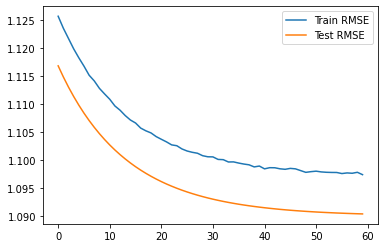

In [6]:
# plot RMSE
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.legend()
plt.show()